## **Multiclass Classifier (OneVsAll)**

In this notenook, we will implement multiclass classification using LogisticRegression with both :

* **SGD** i.e. SGDClassifier(loss='log')

* **solvers** i.e. LogisticRegression(solver='lbfgs')

### **Imports**

In [1]:
# Common imports 
import numpy as np
from pprint import pprint  

# to make this notebook's output stable across runs
np.random.seed(42) 

# sklearn specific imports 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import make_pipeline 
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model  import SGDClassifier, RidgeClassifier, LogisticRegression 
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict 

from sklearn.metrics import log_loss 
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score, recall_score, classification_report 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_curve, roc_auc_score 

#scipy 
from scipy.stats import loguniform 

# To plot pretty figures 
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns;sns.set()

# global settings 
mpl.rc('axes',labelsize=14) 
mpl.rc('xtick',labelsize=12) 
mpl.rc('ytick',labelsize=12) 
mpl.rc('figure',figsize=(8,6))

import warnings 
warnings.filterwarnings('ignore')

#### **Getting Data**

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

#### **Data Preprocessing and Splitting**

In [3]:
X = X.to_numpy()
y = y.to_numpy()

In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **Multiclass LogisticRegression using SGDClassifier**

#### **Model Building**

In [6]:
estimator = SGDClassifier(loss='log', penalty="l2", alpha=0, max_iter=1, random_state=1729, learning_rate="constant", eta0=0.01 ,warm_start=True)

pipe_sgd_ova = make_pipeline(MinMaxScaler() ,estimator)

In [7]:
loss = []
iter = 100 

for i in range(iter):
    pipe_sgd_ova.fit(X_train ,y_train)

    y_pred = pipe_sgd_ova.predict_proba(X_train)
    loss.append(log_loss(y_train ,y_pred))

Visualization of Loss VS iterations

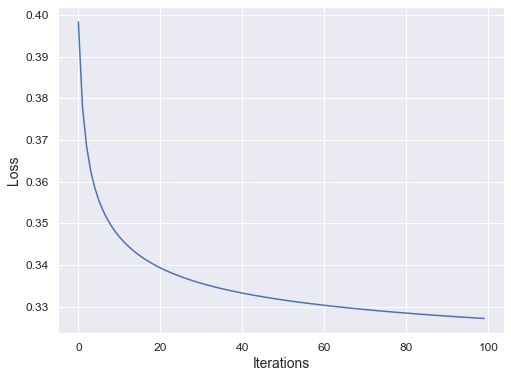

In [8]:
plt.figure()
plt.plot(np.arange(iter), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

What happened behind the screen is that the library automatically created 10 binary classifiers and trained them. 

During the inference time, the input will be passed through all the 10 classifiers and the highest score among the outputs will be considered as the predicted class. 

To see it in action, let's execute the following lines of code : 

In [9]:
pipe_sgd_ova[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [10]:
pipe_sgd_ova[1].coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
pipe_sgd_ova[1].coef_.shape

(10, 784)

So it is a matrix of size $10$ X $784$ . A row represents the weights of a single binary classifier.

In [12]:
y_hat = pipe_sgd_ova.predict(X_test) 
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

#### **Evaluating Metrics**

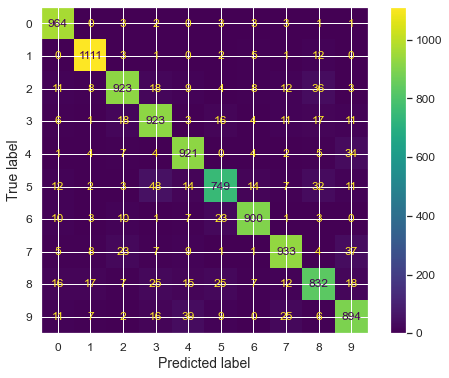

In [13]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test ,y_hat, values_format='.5g')

plt.show()

In [14]:
print(classification_report(y_test ,y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



### **Multiclass LogisticRegression using solvers**

#### **Model Building**

In [15]:
pipe_logreg_ova = make_pipeline(MinMaxScaler() ,LogisticRegression(solver='lbfgs' ,C=np.infty ,random_state=1729))

pipe_logreg_ova.fit(X_train ,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

#### **Making predictions**

In [16]:
y_hat = pipe_logreg_ova.predict(X_test)

#### **Evaluating Metrics**

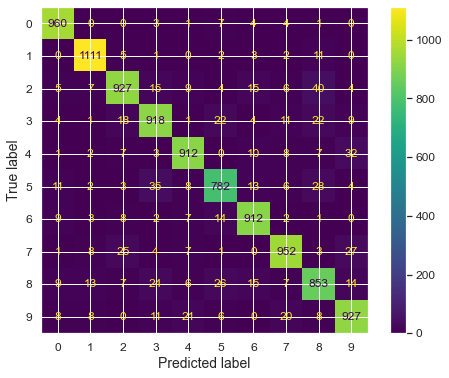

In [17]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test ,y_hat ,values_format='.5g')

plt.show()

In [18]:
print(classification_report(y_test ,y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



### **Visualize weight values**

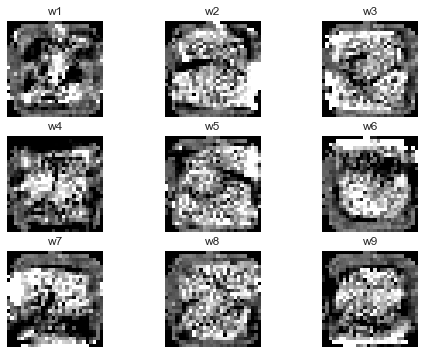

In [19]:
w = pipe_logreg_ova[1].coef_

# normalization 
w = MinMaxScaler().fit_transform(w)
fig, ax = plt.subplots(3,3)
index = 1

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(w[index, :].reshape(28,28) ,cmap='gray')
        ax[i][j].set_title('w{0}'.format(index))
        ax[i][j].set_axis_off()
        index += 1